In [1]:
### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle

# Extract data from Serpent detector files
We can use the read_det_file function from ml_utilities to parse all of the detector files we have in the training data directory to create one pair of unified features/target dataframes.

Sometimes the file(s) provided will have really high uncertainty. This will absolutely limit your model's accuracy, so don't be disheartened until I get you more accurate data, which can take a while to run.

In [2]:
training_steps = [1, 11, 22]
all_features = pd.DataFrame([])
all_targets = pd.DataFrame([])
for i in training_steps:
    # Load the Serpent Detector file, a matlab format file that has pebble surface flux
    # and overall core flux. 
    det_name = f"gFHR_equilibrium_training_{i}.serpent_det0.m"
    
    # Load the auxiliary feature file, which are additionally features I included from
    # the model that tell you more about the respective pebble for each surface
    aux_name = f"current_auxiliary_features{i}.csv"
    features, targets, pebble_ids, avg_uncertainty = read_det_file("training_data/"+det_name, 
                                                                    normalize_and_label=True)
    aux_features = pd.read_csv("training_data/"+aux_name, index_col=0)
    
    # Read the pebble power file and grab the corresponding power values
    pow_name = f"pebble_positions_{i}.csv_pow0.m"
    pow_data = pd.read_csv("training_data/"+pow_name, delimiter='\s+', 
                           names=['x','y','z','rad','universe','power','unc'])
    targets['power'] = pow_data['power'].iloc[pebble_ids].reset_index().drop(columns='index')
    features = aux_features.join(features)
    
    # Convert coordinates to 2D cylindrical, since the flux map is symmetrical
    features['radius'] = round(np.sqrt(features['x']**2+features['y']**2),1)
    features['height'] = round(features['z'],1)
    features = features.drop(columns=['x','y','z'])
    
    print(f"File {det_name} has an average {round(avg_uncertainty*100,2)}% uncertainty.")
    all_features = pd.concat([all_features, features])
    all_targets = pd.concat([all_targets, targets])

# For clarity, re-order the radius and height columns to be first and save
headers = all_features.columns.to_list()
headers.remove("radius")
headers.remove("height")
all_features = all_features[["radius"]+["height"]+headers]

all_features.to_csv("training_data/current_data.csv")
all_targets.to_csv("training_data/current_target.csv")


File gFHR_equilibrium_training_1.serpent_det0.m has an average 12.02% uncertainty.
File gFHR_equilibrium_training_11.serpent_det0.m has an average 7.55% uncertainty.
File gFHR_equilibrium_training_22.serpent_det0.m has an average 8.55% uncertainty.


Our features include the radius and height of the pebble-based detector. It also includes every bin of the core flux map. The gFHR model is divided into 12 energy groups and has 4 radial divisions, each divided into 10 separate axial zones. Normally you would need to volume-weight these flux values, and deal with the somewhat complicated indexing scheme to sort out which is which. We don't need to bother here, since they're all going to be standardized anyways and the model will make its own inferences about the spatial distribution.

In [3]:
all_features.iloc[-10:-1]

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,binR3Z8E18,binR4Z8E18,binR1Z9E18,binR2Z9E18,binR3Z9E18,binR4Z9E18,binR1Z10E18,binR2Z10E18,binR3Z10E18,binR4Z10E18
3990,110.1,106.9,0.000032,3.773827e-08,0.003436,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3991,95.3,254.7,0.000031,4.445037e-08,0.003473,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3992,58.5,160.3,0.000033,4.725760e-08,0.003422,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3993,42.7,307.2,0.000034,4.740853e-08,0.003362,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3994,66.0,329.0,0.000016,5.367337e-08,0.004044,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3995,58.5,179.1,0.000033,4.722993e-08,0.003426,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3996,75.4,89.3,0.000032,4.010948e-08,0.003435,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3997,52.2,324.3,0.000033,4.624174e-08,0.003389,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11
3998,114.4,124.6,0.000032,4.100081e-08,0.003455,1.301132e+20,1.210239e+20,1.019706e+20,9.662874e+19,1.283641e+20,...,6.883077e+11,5.486845e+11,7.083161e+11,6.573777e+11,5.675297e+11,4.520050e+11,4.283921e+11,3.924459e+11,3.302838e+11,2.520474e+11


Meanwhile, the target variables represent the neutron current going into the pebbles above, divided into the same 12 energy bins. There's a tradeoff between how fine our energy grid is, and how long it takes for the Serpent model to run. Every time you add a new bin, you need to simulate more particles to get sufficient statistics. So, our goal is to maximize accuracy using as few bins as possible.

In [9]:
all_targets.iloc[0:10]

,2.9005e-08,9.9e-08,2.1e-07,4.525e-07,7.985000000000001e-07,1.061e-06,1.5025e-06,2.9275e-06,6.9385e-06,1.29225e-05,8.234799999999999e-05,0.002839364,0.007324,0.060059,0.3055,0.6605,1.5259999999999998,6.1155,power
0,7.521810e+13,2.296940e+14,2.601430e+14,1.517750e+14,4.576870e+13,1.843990e+13,3.207780e+13,4.530800e+13,8.276560e+13,4.247150e+13,2.226990e+14,4.202590e+14,7.176590e+13,3.060270e+14,1.511140e+14,7.651530e+13,1.690220e+14,6.137510e+13,797.086
1,1.288390e+14,2.957060e+14,3.035910e+14,1.506420e+14,3.927580e+13,6.221970e+12,3.759940e+13,5.069570e+13,7.171990e+13,2.718650e+13,1.761660e+14,3.414380e+14,4.359710e+13,2.252180e+14,1.351310e+14,4.964670e+13,1.274430e+14,3.622090e+13,950.925
2,1.574750e+14,3.491190e+14,4.308930e+14,2.516200e+14,7.637080e+13,2.070090e+13,5.665870e+13,8.169960e+13,9.772030e+13,5.834760e+13,3.326930e+14,5.704750e+14,9.273520e+13,4.308400e+14,2.584410e+14,9.482760e+13,1.957230e+14,6.621530e+13,1262.310
3,9.289470e+13,2.882190e+14,3.328780e+14,2.535090e+14,1.063370e+14,2.030070e+13,7.501210e+13,1.306780e+14,1.330360e+14,8.866810e+13,4.853850e+14,9.425920e+14,1.203470e+14,6.170240e+14,2.759670e+14,1.301450e+14,2.353390e+14,9.656350e+13,1099.230
4,1.458510e+14,3.336470e+14,3.548030e+14,2.126570e+14,6.514330e+13,1.657510e+13,5.808070e+13,8.472370e+13,9.968180e+13,5.483560e+13,2.864000e+14,5.685470e+14,7.786030e+13,4.321820e+14,2.330110e+14,9.696060e+13,2.119090e+14,7.406250e+13,1228.780
5,8.597010e+13,2.207200e+14,2.358660e+14,1.783480e+14,7.148980e+13,2.173710e+13,5.097040e+13,9.470580e+13,1.169460e+14,7.576880e+13,3.488320e+14,6.541130e+14,9.381620e+13,4.968790e+14,2.238730e+14,1.016950e+14,2.146410e+14,6.007700e+13,911.370
6,9.407920e+13,2.516560e+14,3.557060e+14,2.417300e+14,7.778940e+13,2.618160e+13,1.051680e+14,1.385660e+14,1.735780e+14,1.098270e+14,4.972260e+14,8.600150e+14,1.426270e+14,6.707050e+14,2.873410e+14,1.215090e+14,2.579440e+14,7.685270e+13,752.956
7,1.156320e+14,3.598990e+14,4.016080e+14,3.666110e+14,1.180230e+14,4.979090e+13,1.191980e+14,1.816530e+14,2.155140e+14,1.099880e+14,6.895520e+14,1.194110e+15,1.859510e+14,8.282280e+14,3.831220e+14,1.900670e+14,3.430080e+14,1.344170e+14,1198.250
8,8.341700e+13,2.632300e+14,3.107450e+14,2.571640e+14,1.068530e+14,3.528890e+13,1.026090e+14,1.563150e+14,1.767090e+14,1.016420e+14,4.833180e+14,8.500930e+14,1.410720e+14,6.292480e+14,3.165580e+14,1.460310e+14,2.443480e+14,9.952540e+13,1012.960
9,1.136390e+14,2.227620e+14,3.407800e+14,2.584610e+14,8.224690e+13,3.299010e+13,7.275480e+13,1.147850e+14,1.648150e+14,1.020200e+14,4.693000e+14,9.036250e+14,1.211340e+14,6.443510e+14,2.774410e+14,1.331410e+14,2.284980e+14,9.337270e+13,1250.200


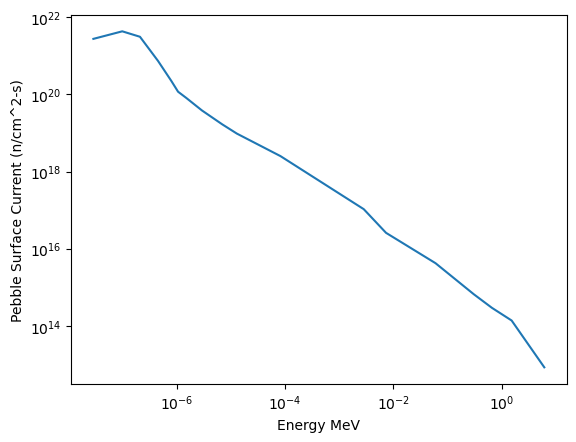

Pebble power: 1262.31


In [15]:
i_to_plot = 2
energies = all_targets.drop(columns="power").columns.to_list()
sample_current = all_targets.drop(columns="power").iloc[i_to_plot].to_list()

# Divide by the energy bin width when plotting to better see the function
plt.plot(energies, sample_current/np.diff(ENERGY_BINS))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Energy MeV")
plt.ylabel("Average Pebble Surface Current (n/cm^2-s)")
plt.show()
print(f"Pebble power: {all_targets.iloc[i_to_plot]['power']}")

# Data Standardization
Simple standardization is performed here along each column. I tried log-standardization, but it didn't seem to help with the current values.

In [25]:
train_split = 0.8
np.random.seed(42)

def standardize(raw_data, mean=None, std=None, axis=0):
    if mean is None:
        mean = np.mean(raw_data, axis = axis)
    if std is None:
        std = np.std(raw_data, axis = axis)
        std[ std==0 ] = 0.1
    result = (raw_data - mean) / std
    return result, mean, std

def unstandardize(standardized_data, mean, std):
    raw_data = (standardized_data*std)+mean
    return raw_data

#log_features = all_features#.apply(lambda x: np.log10(x + 1))
#log_targets = all_targets
#log_targets.iloc[:,2:] = all_targets.iloc[:,2:]#.apply(lambda x: np.log10(x + 1))

num_data = len(all_features)
training_size = int(num_data*train_split)
testing_size = num_data - training_size
data_indices = np.arange(num_data)
training_indices = np.random.choice(num_data, training_size, replace=False)
testing_indices = data_indices[np.in1d(data_indices, training_indices, invert=True)]

training_data, data_mean, data_std = standardize(all_features.iloc[training_indices])
training_target, target_mean, target_std = standardize(all_targets.iloc[training_indices])
testing_data, _, _  = standardize(all_features.iloc[testing_indices], mean=data_mean, std=data_std)
testing_target, _, _  = standardize(all_targets.iloc[testing_indices], mean=target_mean, std=target_std)

print(np.shape(training_data))
print(np.shape(training_target))
print(np.shape(testing_data))
print(np.shape(testing_target))

(9600, 725)
(9600, 19)
(2400, 725)
(2400, 19)


# Model Training
I threw together a quick RFR model and got some results. You're free to change to any other type of model, as long as its something I can save and load into other modules. Things to try:
- Properly using cross validation
- Tuning the hyper parameters
- Trying a different model, probably a neural net

In [26]:
best_params = {'max_depth': 12, 
               'n_estimators': 1000, 
               'n_jobs': 24,} # Set to your number of cores
rfr_model = RandomForestRegressor(random_state=0)
rfr_model.set_params(**best_params)
rfr_model.fit(training_data, training_target)
rfr_model_test_score = rfr_model.score(testing_data, testing_target)
print(f"RFR score: {rfr_model_test_score}")

RFR score: 0.8907448730778139


Next we save the models and standardization parameters so the model can be used in the simulation.

In [27]:
model_data = pickle.dumps(rfr_model)
with open("ml_models/current_rfr.pkl", 'wb') as f:
    f.write(model_data)
data_mean.to_csv("ml_models/current_rfr_data_mean.csv", header=True)
data_std.to_csv("ml_models/current_rfr_data_std.csv", header=True)
target_mean.to_csv("ml_models/current_rfr_target_mean.csv", header=True)
target_std.to_csv("ml_models/current_rfr_target_std.csv", header=True)